In [10]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import scipy.io
from scipy import interpolate
import scipy.ndimage
import xarray as xr
import pickle
import matplotlib.cm as cm

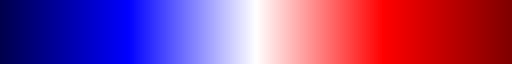

In [11]:
# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')
dcmap

In [2]:
def make_grid(name=None, e0=None, n0=None, xlen=None, ylen=None, dxdy=None, theta=None):
    """
    Make a rectangular grid to interpolate elevations onto.
    Takes as argument array of dicts, like:
    r={'name': 'ncorebx_refac', 'e0': 378490., 'n0': 3855740., 'xlen': 36500.0, 'ylen': 1500.0, 'dxdy': 1.0, 'theta': 42.0}
    where:
      e0 - UTM Easting of origin [m]
      n0 - UTM Northing of origin [m]
      xlen - Length of alongshore axis [m]
      ylen - Length of cross-shore axis [m]
      dxdy - grid size (must be isotropic right now) [m]
      theta - rotation CCW from x-axis [deg]
    """
    nx = int((1./dxdy) * xlen)
    ny = int((1./dxdy) * ylen)

    xcoords = np.linspace(0.5*dxdy,xlen-0.5*dxdy,nx)
    ycoords = np.linspace(0.5*dxdy,ylen-0.5*dxdy,ny)

    # these will be the coordinates in rotated space
    xrot, yrot = np.meshgrid(xcoords, ycoords, sparse=False, indexing='xy')

    print('make_grid: Shape of xrot, yrot: ',np.shape(xrot),np.shape(yrot))
    shp = np.shape(xrot)
    xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, theta)
    xu=np.reshape(xu,shp)
    yu=np.reshape(yu,shp)
    # write the UTM coords of the corners to an ASCII file
    corners = np.asarray(  [[xu[0][0],yu[0][0]],
                           [xu[0][-1],yu[0][-1]],
                           [xu[-1][-1],yu[-1][-1]],
                           [xu[-1][0],yu[-1][0]],
                           [xu[0][0],yu[0][0]]])

    print('corners x, corners y]')
    print(corners)
    fn_corners = name+'.csv'
    print('Saving to '+fn_corners)
    np.savetxt(fn_corners, corners, delimiter=",")
    return xu, yu, xrot, yrot, xcoords, ycoords


def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        x_r, y_r - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),
                   (s,  c,  0.),
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),
                   (0., 1., y0),
                   (0., 0., 1.)))

    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh = np.matmul(np.matmul(Th,Rh), xyh)
    x_r = xyrh[0,:]
    y_r = xyrh[1,:]
    return x_r, y_r


def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r = np.sqrt(x**2 + y**2)
    az = np.degrees(np.arctan2(x, y))
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az


def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y


def UTM2Island(eutm, nutm, eoff=383520.0, noff=3860830.0, rot=42.0):
    """
    Convert UTM NAD83 Zone 18N easting, northing to N. Core Banks alongshore, cross-shore coordinates
    xisl, yisl = UTM2Island( eutm, nutm )
    Better to use values from the dict than defaults for translation/rotation values
    Defaults are associated with the dict read in from `small_island_box.yml`
    """
    [r, az] = pcoord(eutm-eoff, nutm-noff)
    az = az + rot
    [xisl,yisl] = xycoord(r,az)
    return xisl, yisl


def island2UTM(alongshore, across_shore, eoff=383520.0, noff=3860830.0, rot=42.):
    """Convert island coordinates to UTM
       Inverse of UTM2Island()
       Better to use values from the dict than defaults for translation/rotation values
       Defaults are associated with the dict read in from `small_island_box.yml`

       Here is code for UTM2island:
          [r, az] = pcoord(eutm-eoff, nutm-noff)
          az = az + rot
          [xisl,yisl] = xycoord(r,az)
    """
    r, az = pcoord(alongshore, across_shore)
    az = az - rot
    eUTM, nUTM = xycoord(r, az)
    eUTM = eUTM + eoff
    nUTM = nUTM + noff
    return eUTM, nUTM


In [4]:
# load and plot the elevation map
ddir = "F:/crs/proj/2024_Sandwich_Surveys/2023_TownNeckBeach/"
fname = ddir+"2023-028-FA_Sandwich_Ricoh_SfM_DSM_UTM19N_NAVD88_25cm.tif"
ds = xr.open_dataset(fname, chunks={'x':256, 'y':256})
ds

<xarray.Dataset> Size: 89MB
Dimensions:      (band: 1, x: 4940, y: 4500)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 40kB 3.763e+05 3.763e+05 ... 3.775e+05 3.775e+05
  * y            (y) float64 36kB 4.625e+06 4.625e+06 ... 4.624e+06 4.624e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 89MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

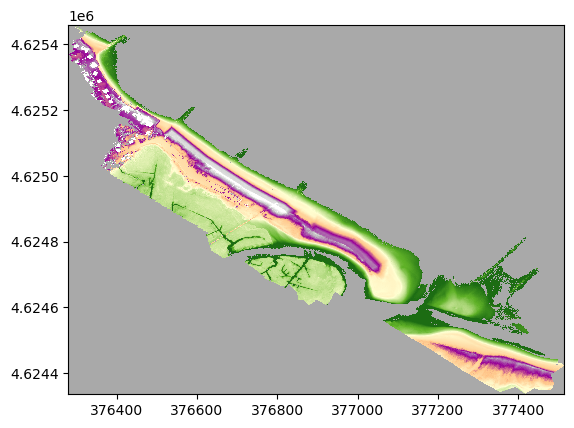

In [12]:
plt.pcolormesh(ds.x, ds.y, np.squeeze( ds.band_data ), cmap=cmap_ncb, vmin=0., vmax=6. )
plt.show()

In [16]:
# make a rotated grid
e0 = 376500.
n0 = 4625100.
az = 127.
theta = 90-az
xlen = 700.
ylen = 100.
xu, yu, xrot, yrot, xcoords, ycoords = make_grid(name='sandwich', e0=e0, n0=n0, xlen=xlen, ylen=ylen, dxdy=1., theta=theta)
ny,nx = np.shape(xu)
print('Size of grid:',ny,nx)

make_grid: Shape of xrot, yrot:  (100, 700) (100, 700)
corners x, corners y]
[[ 376500.70022527 4625100.09841024]
 [ 377058.94644679 4624679.42970906]
 [ 377118.52613408 4624758.49462456]
 [ 376560.27991256 4625179.16332574]
 [ 376500.70022527 4625100.09841024]]
Saving to sandwich.csv
Size of grid: 100 700


In [30]:
easting = ds.x.values
northing = ds.y.values
elev = np.squeeze( ds.band_data.values )

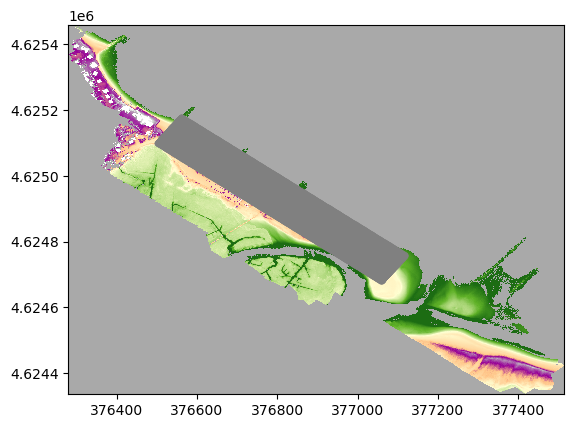

In [31]:
plt.pcolormesh(easting, northing, elev, cmap=cmap_ncb, vmin=0., vmax=6. )
plt.plot( xu, yu, '.', c='gray')
plt.show()

In [36]:
print( np.shape(easting), np.shape(northing), np.shape(elev) )

(4940,) (4500,) (4500, 4940)


In [39]:
f = interpolate.RegularGridInterpolator( (northing, easting), elev, method='nearest')   

# Array for interpolated elevations
zi=np.nan*np.ones((ny,nx))
    
# this is the fast iteration, which only works when all of the source points fall inside the target box
try:
    zi=f((yu,xu))

# this is a slow iteration through all of the points, but allows us to skip ones that are outside
except:
    if(not iswarned):
        print("Warning: using slow iteration.")
        iswarned = True
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN


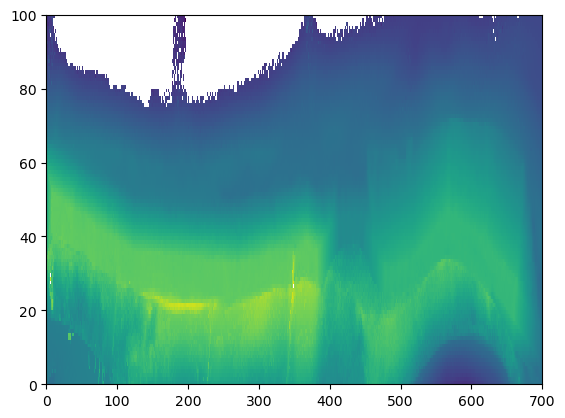

In [41]:
plt.pcolormesh(xrot, yrot, zi)

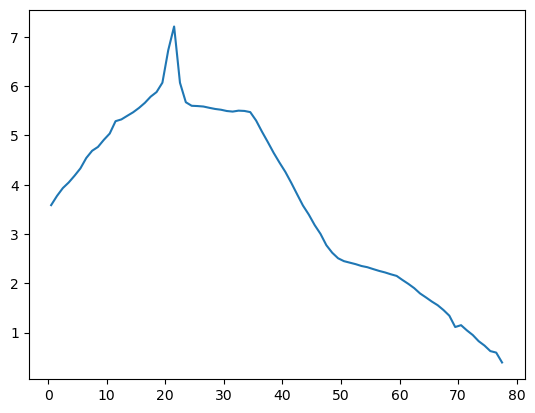

In [43]:
plt.plot(yrot[:,200],zi[:,200])